# Predictive Maintainance Analysis for sensor data:

### Initialization:

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [199]:
data0=pd.read_csv('sensor.zip', parse_dates=["timestamp"]) #adjust path to .csv file

In [200]:
data0.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


### Remark:

While looking up information and knowledge on predictive maintainance and working with panda, I came across two webpages that use the same data. https://towardsdatascience.com/lstm-for-predictive-maintenance-on-pump-sensor-data-b43486eb3210 and https://www.kaggle.com/code/alokkumar4723/predictive-maintainance/notebook. Wheras the Kaggle code is simple, it does not predict anything as it just reconstructs the target variable (as also mentioned in a comment to it), the first article explains very nicely and comprehensivley the complete structure and workflow of a predictive maintainance analysis.
I chose to follow the workflow detailed there in general, but made different decisions in the single steps. The decisions were influenced by various online articles (that I dont acknowledge) and the conference paper: https://www.researchgate.net/profile/Ger-Koole-2/publication/339404826_A_Comparative_Study_of_State-of-the-Art_Machine_Learning_Algorithms_for_Predictive_Maintenance/links/5ef1bbf6a6fdcc73be96d7ba/A-Comparative-Study-of-State-of-the-Art-Machine-Learning-Algorithms-for-Predictive-Maintenance.pdf 
The last paper is also the reason that I dont use a LSTM model as it does not outcompete simpler models and is already done in the first linked article. My main focus model is a logistic regression as this is very fitting for {0,1} targets.

## Manual data exploration with focus on resolving NaNs:

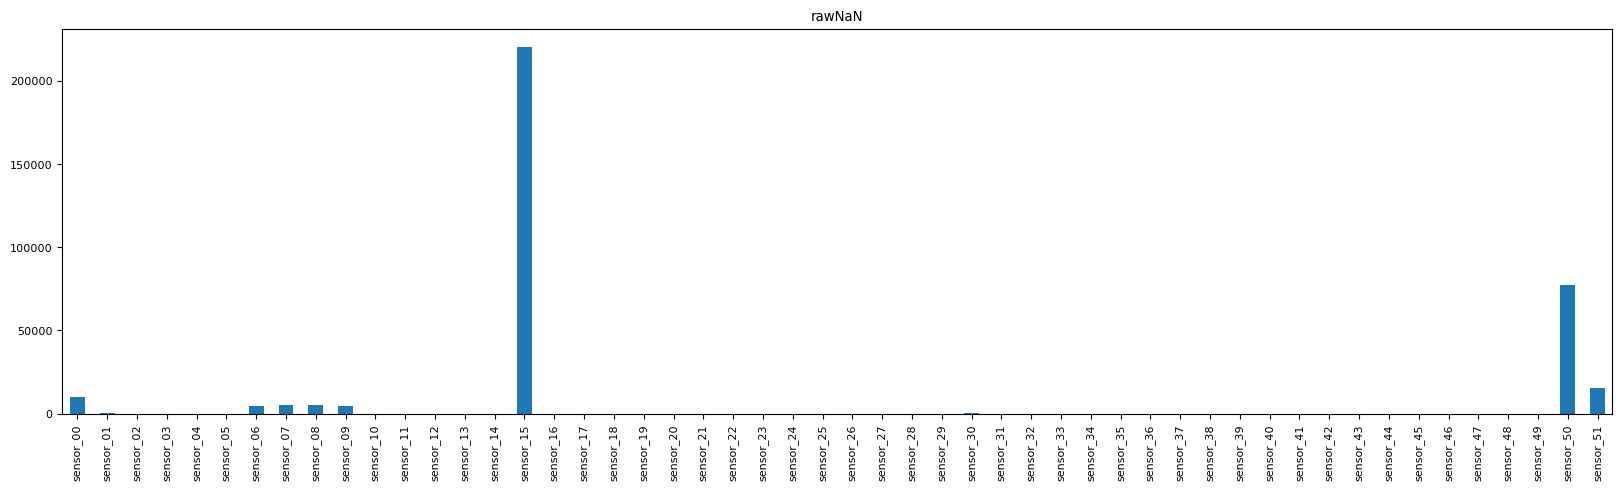

In [201]:
data0.isna().sum()[2:-1].plot(kind='bar')
plt.title('rawNaN');

Plot of all missing data points. In sensor 15 there is no data point at all. We drop it

In [202]:
data0['sensor_15'].isnull().all(axis=0)

True

In [203]:
data0.drop('sensor_15',axis=1, inplace=True)

C:\Users\aboas\AppData\Local\Temp\ipykernel_14616\4268903296.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_cluster2 = data0.corr()


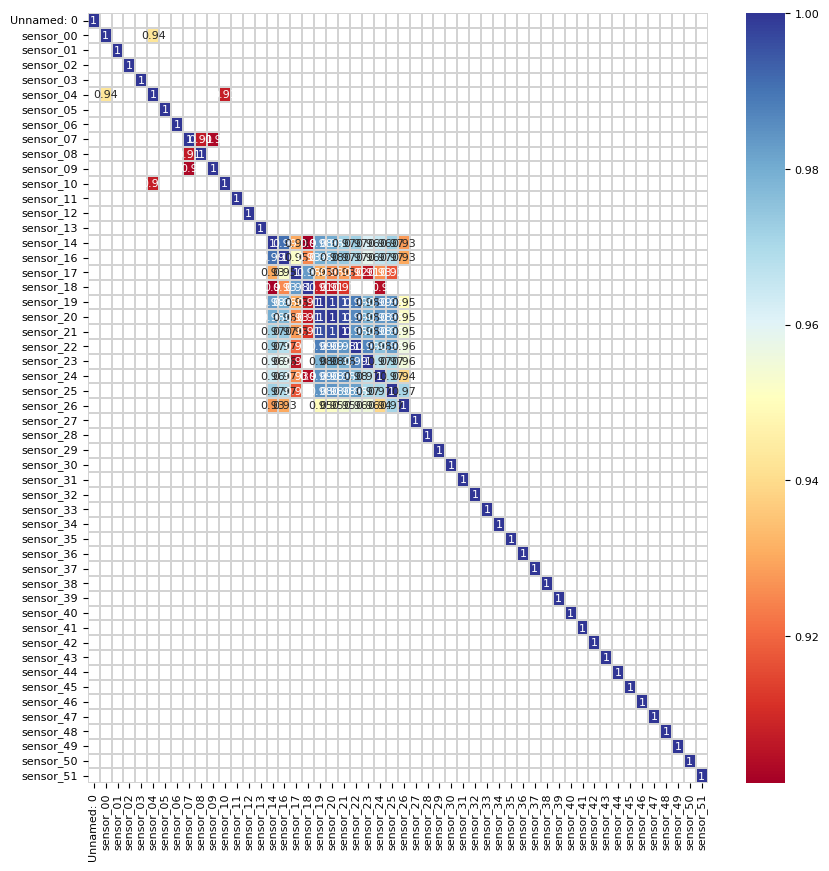

In [204]:
plt.figure(figsize=(10,10))
threshold = 0.90
#sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = data0.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2, 
            linecolor='lightgrey').set_facecolor('white')

In [205]:
# drop all but one of the highly correlated features
cor_matrix = data0.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(corr_features)
data0.drop(corr_features,axis=1,inplace=True)

C:\Users\aboas\AppData\Local\Temp\ipykernel_14616\1318183053.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_matrix = data0.corr().abs()


['sensor_04', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']


C:\Users\aboas\AppData\Local\Temp\ipykernel_14616\1318183053.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


#### Sensors 50 and 51:

<AxesSubplot: >

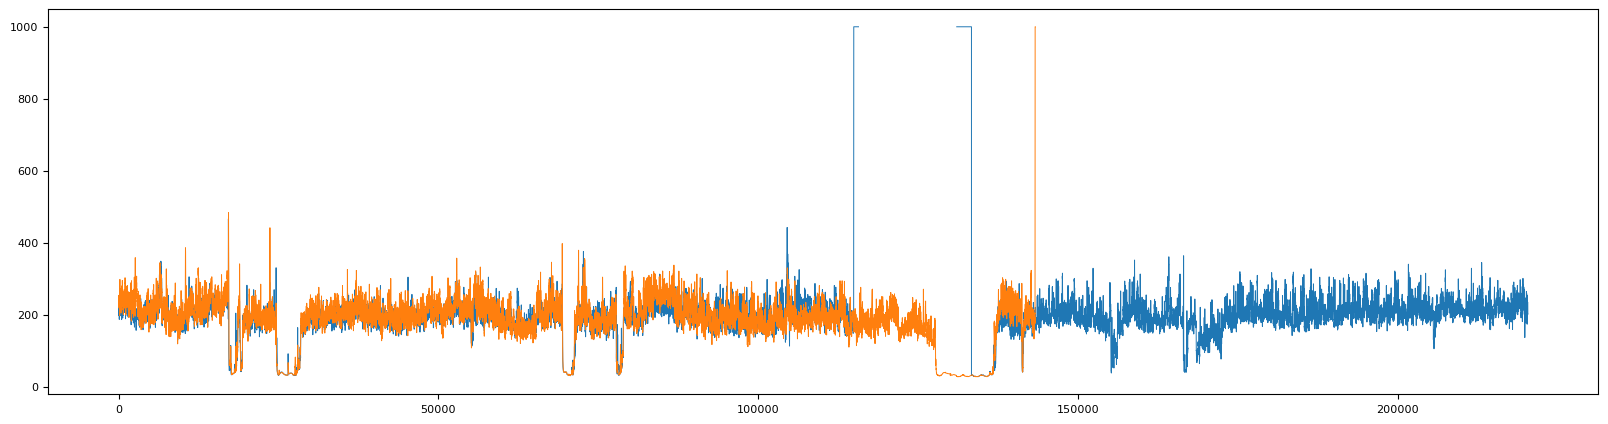

In [206]:
data0["sensor_51"].plot()
data0["sensor_50"].plot()

A lot of missing data in sensors 50 and 51, but they overlap a lot. I repair 50 by using 51

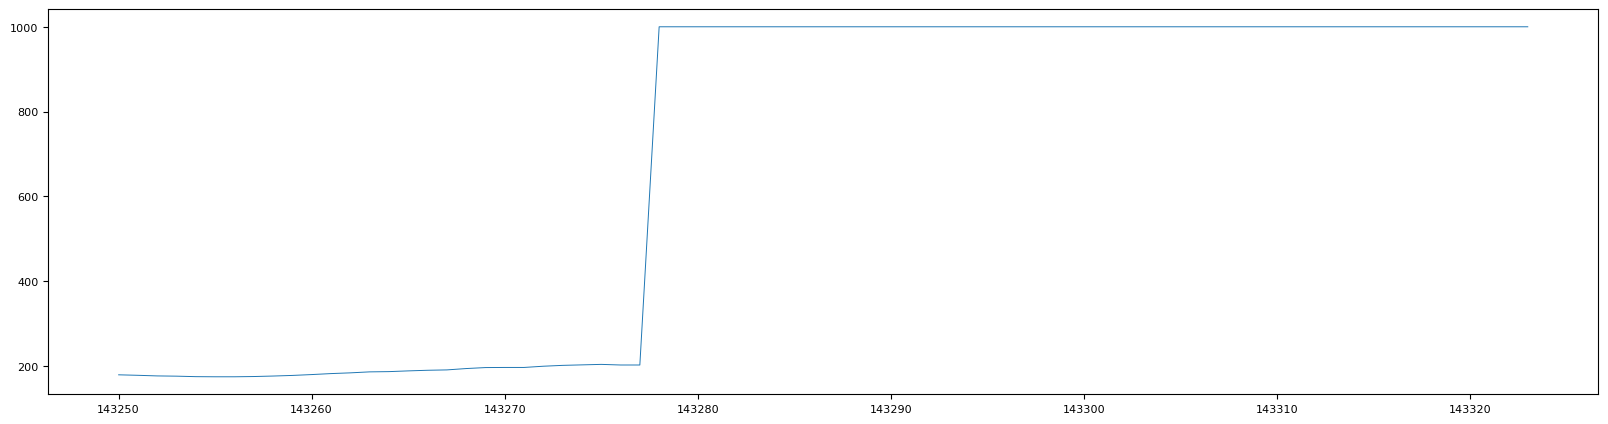

In [207]:
data0["sensor_50"][143250:].plot();

C:\Users\aboas\AppData\Local\Temp\ipykernel_14616\4184366639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data0["sensor_50"][143250:]=data0["sensor_51"][143250:]


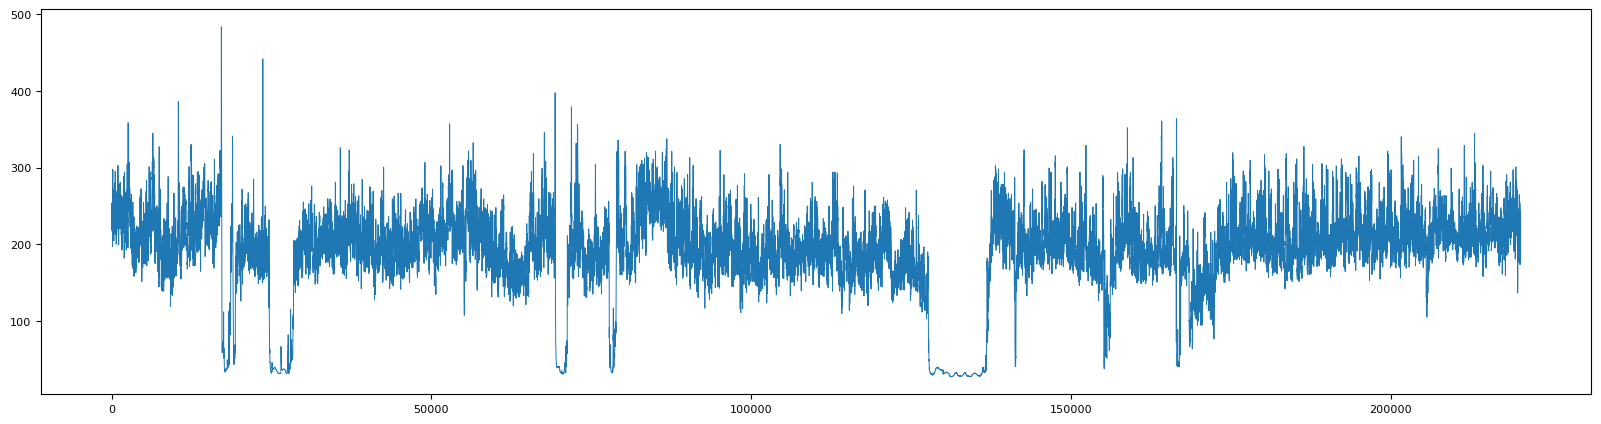

In [208]:
data0["sensor_50"][143250:]=data0["sensor_51"][143250:]
data0.drop("sensor_51", axis=1, inplace=True)
data0["sensor_50"].plot();

Text(0.5, 1.0, 'NaN - without 15 and 51')

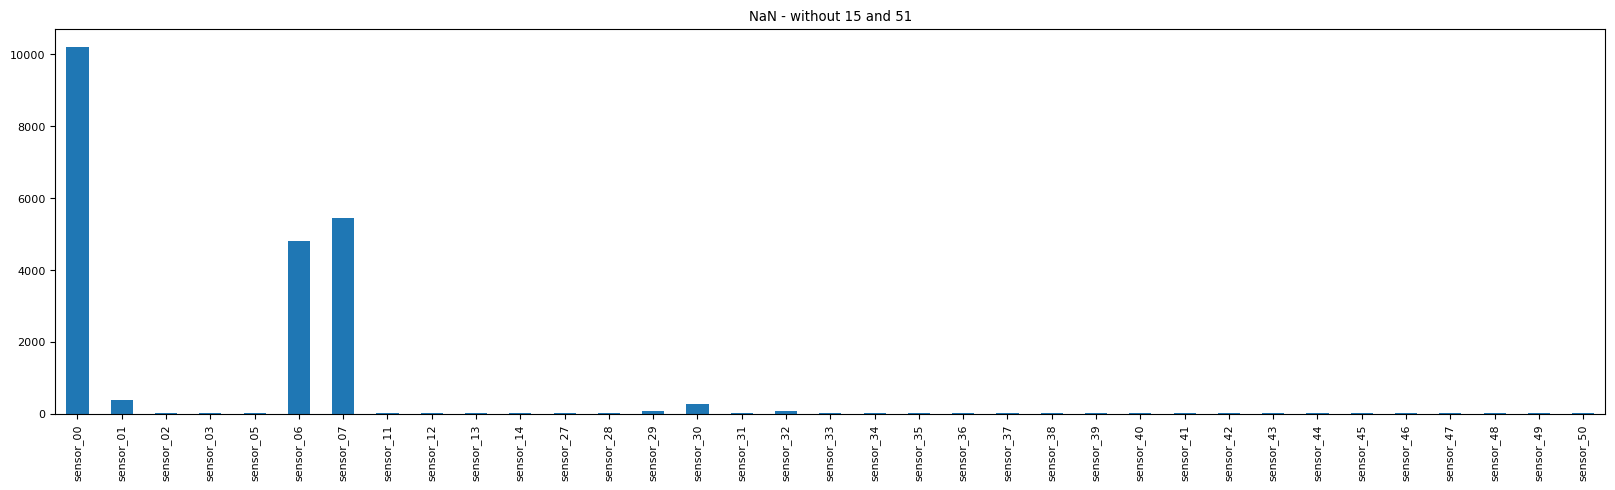

In [209]:
data0.isna().sum()[2:-1].plot(kind='bar')
plt.title('NaN - without 15 and 51')

#### We look at sensors 00, 06, 07, 08 and 09:

In [210]:
nan00=data0.loc[data0["sensor_00"].isna()==True].fillna(0)
nan06=data0.loc[data0["sensor_06"].isna()==True].fillna(0)
nan07=data0.loc[data0["sensor_07"].isna()==True].fillna(0)

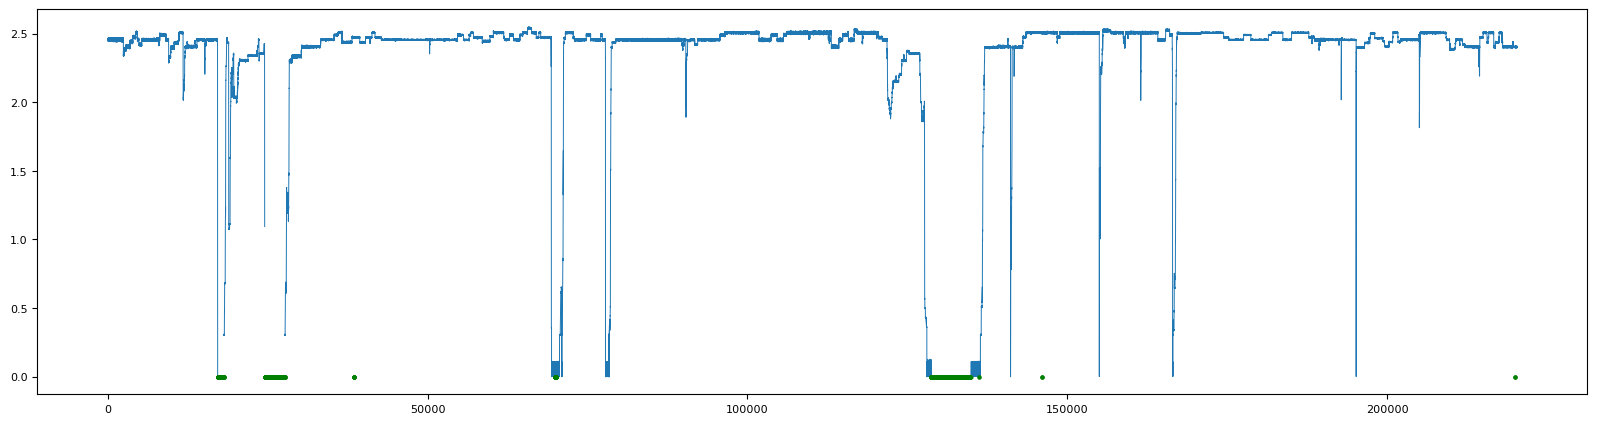

In [211]:
data0["sensor_00"].plot(subplots =True)
plt.plot(nan00["sensor_00"], 'go', markersize=2)

I fill all the NAN with 0 and compare it to the original plot.

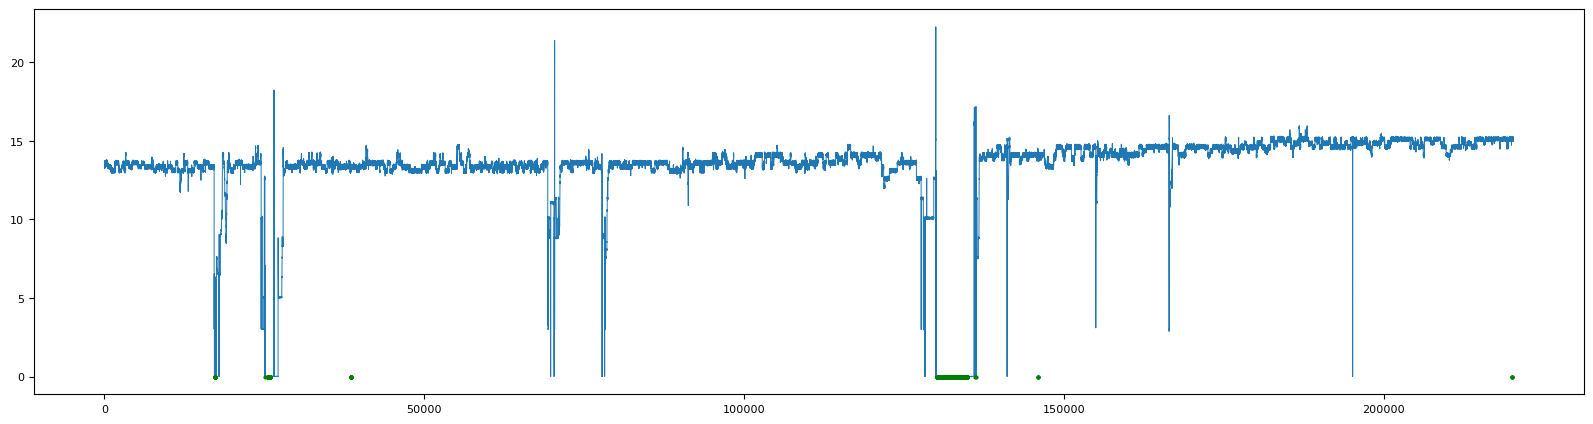

In [212]:
data0["sensor_06"].plot()
plt.plot(nan06["sensor_06"], 'go', markersize=2)

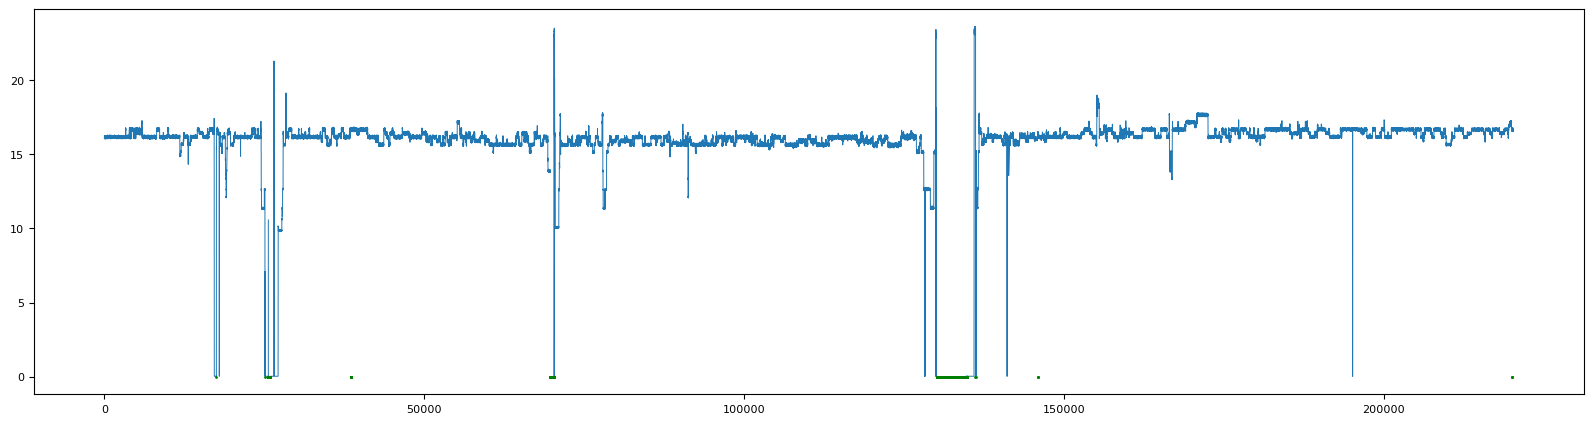

In [213]:
data0["sensor_07"].plot()
plt.plot(nan07["sensor_07"], 'go', markersize=1)

The NAN occur mostly between data points that are zero. Thus, I believe in these cases, it makes sense to replace nan by 0.

In [214]:
data0["sensor_00"].fillna(0, inplace=True)
data0["sensor_06"].fillna(0, inplace=True)
data0["sensor_07"].fillna(0, inplace=True)

Text(0.5, 1.0, 'NaN - without 15 and 51 and resolved 0,6 and 7')

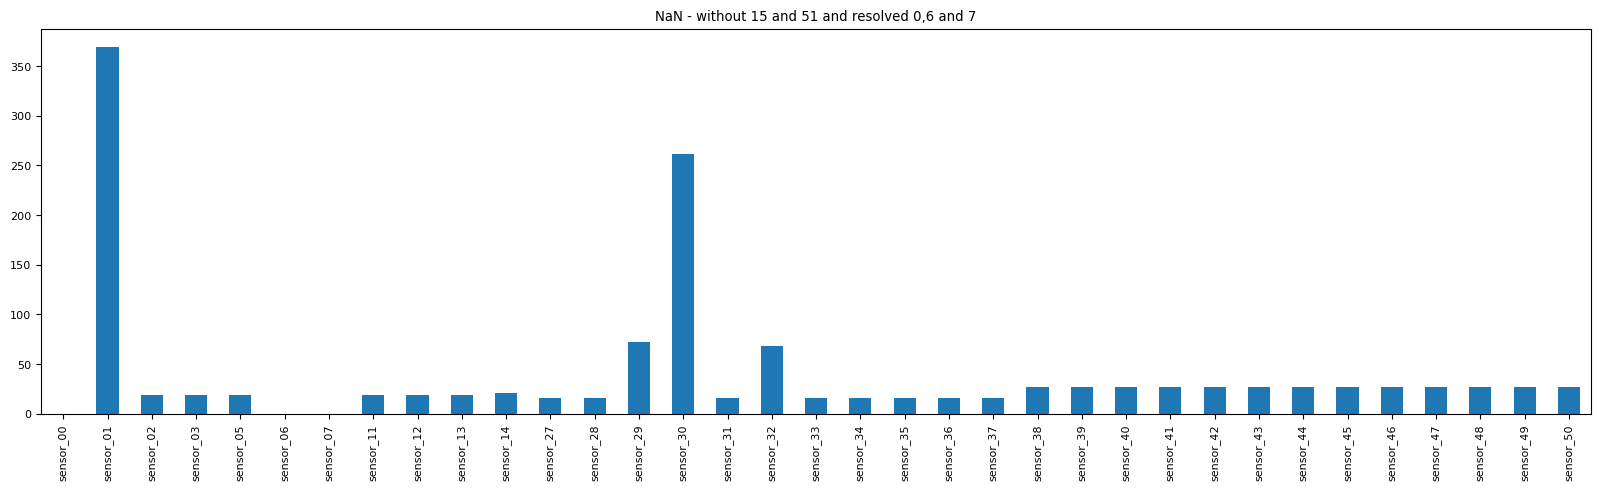

In [215]:
data0.isna().sum()[2:-1].plot(kind='bar')
plt.title('NaN - without 15 and 51 and resolved 0,6 and 7')

### the remaining NaNs get resolved by the folowing code that does not remove them if they occurr in sequences greater than 150:

In [216]:
data0.fillna(method="pad",limit=150, inplace=True)

Text(0.5, 1.0, 'NaN - most NaNs filled or dropped')

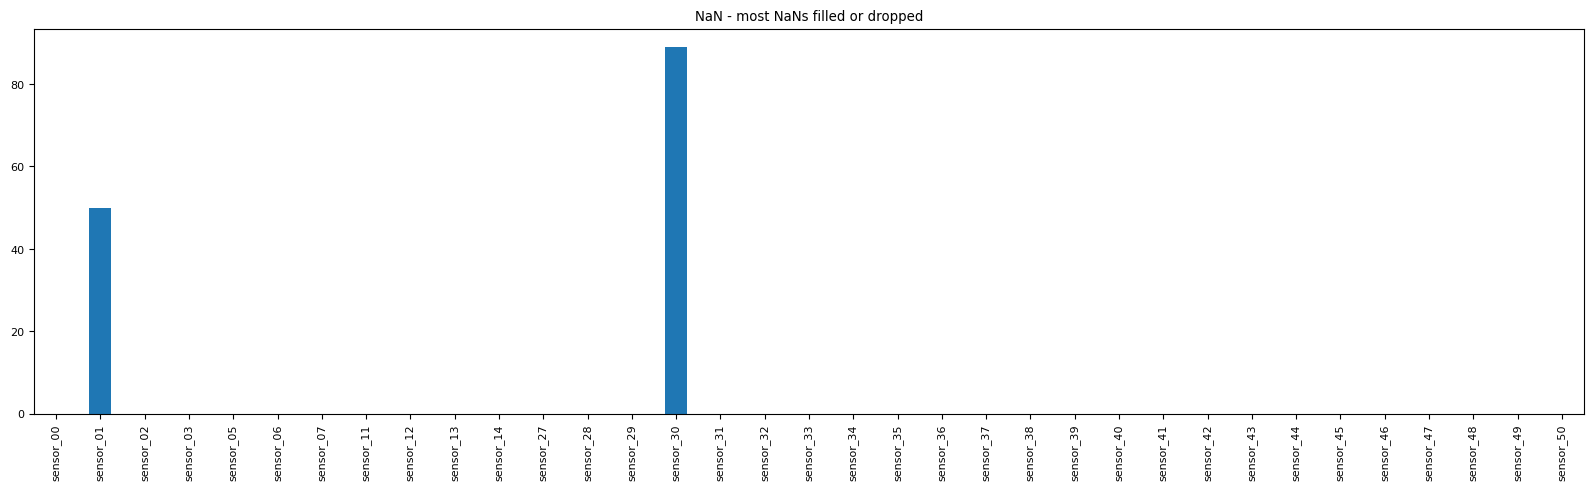

In [217]:
data0.isna().sum()[2:-1].plot(kind='bar')
plt.title('NaN - most NaNs filled or dropped')

In [218]:
nan01=data0.loc[data0["sensor_01"].isna()==True].fillna(0)
nan30=data0.loc[data0["sensor_30"].isna()==True].fillna(0)

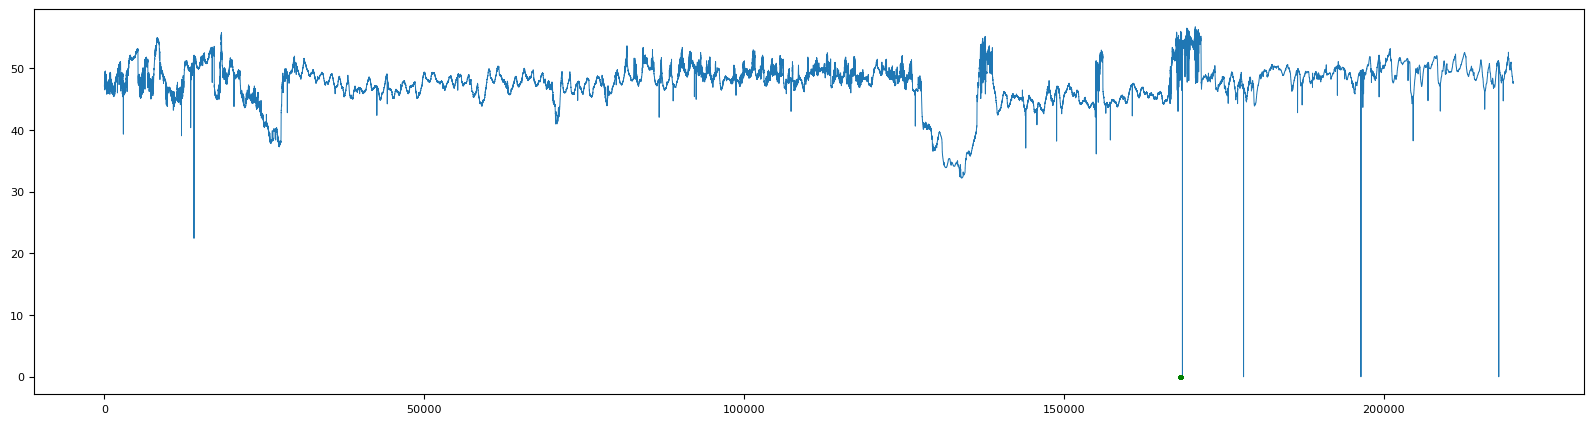

In [219]:
data0["sensor_01"].plot()
plt.plot(nan01["sensor_01"], 'go', markersize=2)

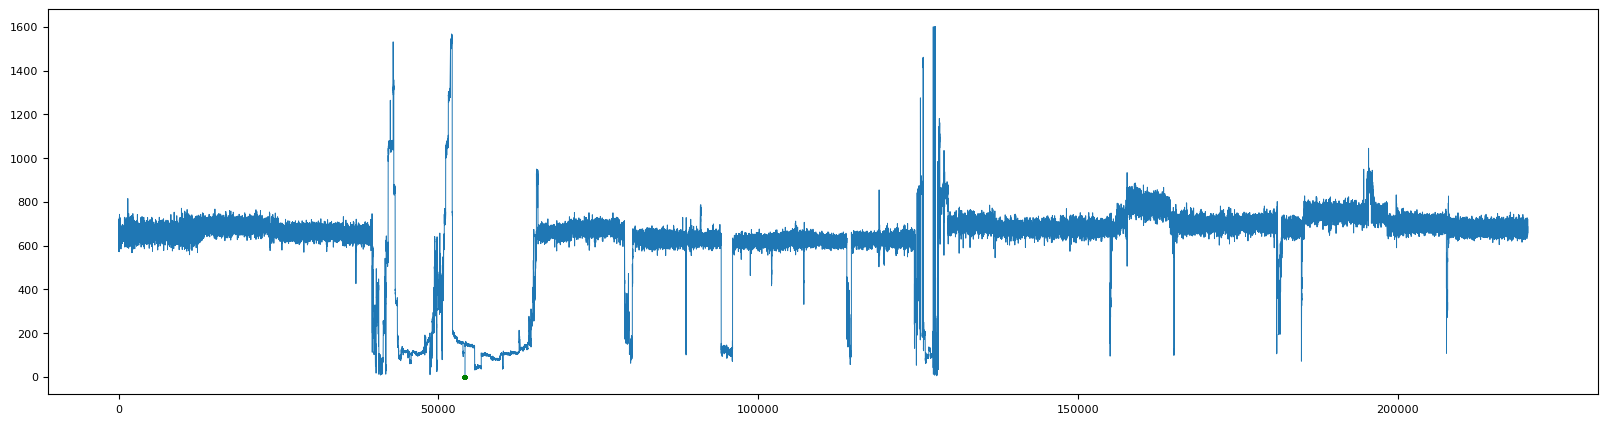

In [220]:
data0["sensor_30"].plot()
plt.plot(nan30["sensor_30"], 'go', markersize=2)

The NaNs for sensors 01 and 30 are well replaced by zero

In [221]:
data0["sensor_01"].fillna(0, inplace=True)
data0["sensor_30"].fillna(0, inplace=True)

In [222]:
data0.isnull().all().sum()

0

no NaN left

C:\Users\aboas\AppData\Local\Temp\ipykernel_14616\2583747813.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_cluster2 = data0.corr()


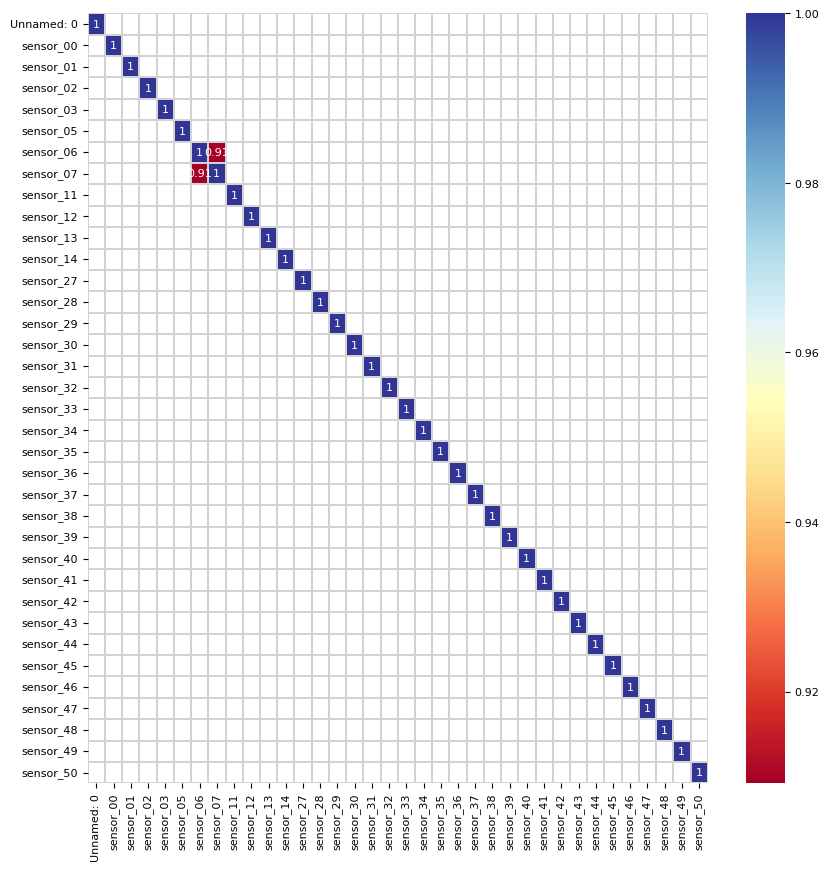

In [223]:
plt.figure(figsize=(10,10))
threshold = 0.90
#sns.set_style("white", {"axes.facecolor": "1"})
df_cluster2 = data0.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2, 
            linecolor='lightgrey').set_facecolor('white')

In [224]:
len(list(data0))

38

## Data preparation for modeling:

In [225]:
data0["machine_status"].replace({"NORMAL": 0,"BROKEN": 1,"RECOVERING": .5}, inplace=True)

<AxesSubplot: >

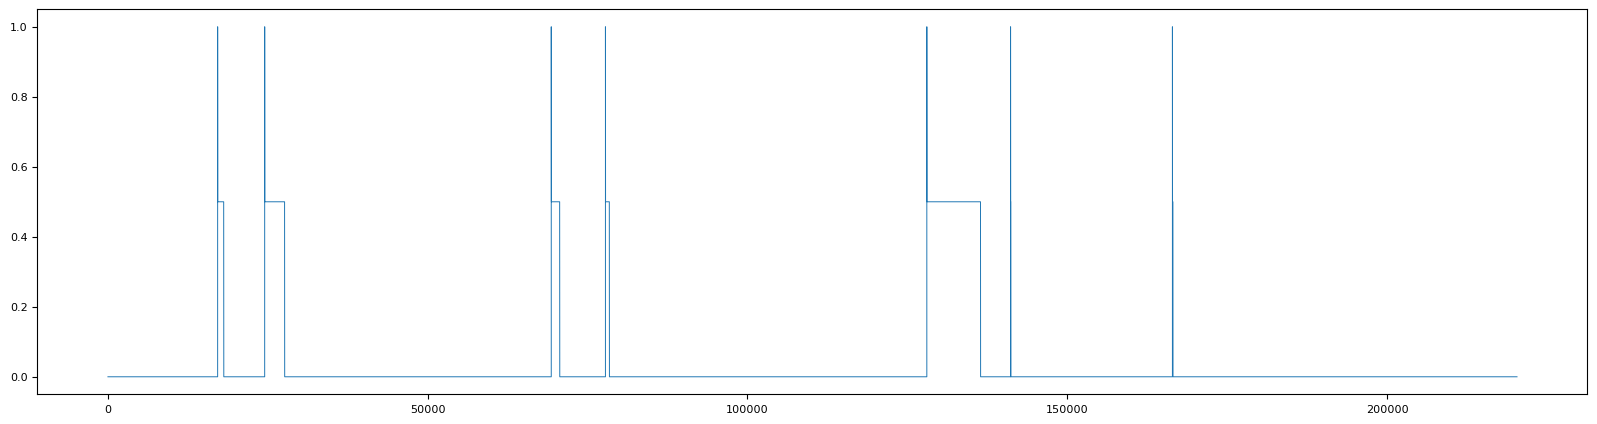

In [226]:
data0["machine_status"].plot()
#plt.xlim([160000,170000])

In https://www.researchgate.net/profile/Ger-Koole-2/publication/339404826_A_Comparative_Study_of_State-of-the-Art_Machine_Learning_Algorithms_for_Predictive_Maintenance/links/5ef1bbf6a6fdcc73be96d7ba/A-Comparative-Study-of-State-of-the-Art-Machine-Learning-Algorithms-for-Predictive-Maintenance.pdf they argue that it makes sense to bin the data.

Thus, I bin the data for thirty minutes. The measurments are taken every minute, thus every row is one minute.

In [30]:
data=data0.groupby(data0.index // 30).agg('mean')

C:\Users\aboas\AppData\Local\Temp\ipykernel_14616\1523785332.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=data0.groupby(data0.index // 30).agg('mean')


In [31]:
data

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_05,sensor_06,sensor_07,sensor_11,sensor_12,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,machine_status
0,14.5,2.454310,48.114871,53.171294,46.338251,76.534324,13.358891,16.163916,51.143477,34.721788,...,31.788193,40.980900,39.853394,55.237267,48.640047,39.457947,195.958717,78.549387,245.331800,0.0
1,44.5,2.454703,48.997393,53.113423,46.112557,74.938555,13.368777,16.160299,51.643845,38.075463,...,32.430553,39.696177,37.692900,44.868828,45.611497,39.168595,198.958330,77.787424,234.972997,0.0
2,74.5,2.454277,47.693865,53.123551,45.959200,74.106842,13.592543,16.150894,53.681407,37.537358,...,32.595484,39.062496,39.882329,46.720680,42.409336,39.236111,166.087970,71.547067,227.064053,0.0
3,104.5,2.454211,48.337672,53.090276,45.911457,75.024932,13.593508,16.162468,51.472240,36.964400,...,33.177080,40.694441,46.556714,47.945602,45.341435,39.371141,195.283567,75.221837,233.593750,0.0
4,134.5,2.453621,49.011861,53.020831,45.763887,75.481911,13.603152,16.163674,52.660772,37.956720,...,32.708331,40.286455,39.998070,42.621528,42.640819,38.126928,180.815973,78.906250,221.585650,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7339,220184.5,2.402955,48.177083,50.580151,43.262440,74.527097,15.109472,16.675108,52.281378,39.353701,...,29.913195,36.336802,51.919368,55.738811,51.186342,38.358409,252.690963,99.392364,208.661267,0.0
7340,220214.5,2.403152,47.744501,50.601851,43.088828,73.575881,15.098138,16.643038,44.018876,33.808914,...,29.687500,40.789927,50.559413,47.376543,44.135803,38.126928,219.029703,91.907794,187.471067,0.0
7341,220244.5,2.402693,47.675056,50.596066,42.938368,73.306727,15.108025,16.678000,48.376846,34.499039,...,30.017361,44.513886,67.486496,42.708332,47.260803,37.577159,229.812890,114.303626,219.521613,0.0
7342,220274.5,2.402234,47.808159,50.528066,43.020831,69.762538,15.127073,16.648584,49.634262,36.937509,...,30.026042,47.517358,55.941358,40.258487,50.848765,38.512731,282.175923,149.488820,240.229557,0.0


In [32]:
data['machine_status'].unique()

array([0.        , 0.1       , 0.5       , 0.16666667, 0.51666667,
       0.35      , 0.21666667, 0.18333333, 0.33333333, 0.38333333,
       0.26666667])

<AxesSubplot: >

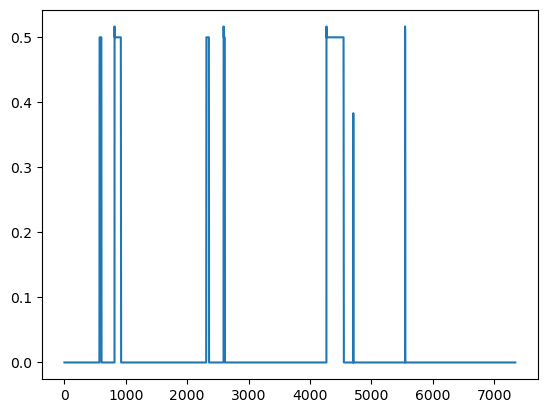

In [33]:
data['machine_status'].plot()

To have more data points I assume all bins that have a positive machine_status entry are broken. Which means, within these thirty minutes something breaks or is in recovery. It is useful for training because if it works correctly there is no Error state any more and subsequently no Recovery needed.   

In [34]:
data['machine_status']=np.ceil(data['machine_status'])

In [35]:
data['machine_status'].unique()

array([0., 1.])

In [36]:
err=data.loc[data['machine_status']==1.]
err

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_05,sensor_06,sensor_07,sensor_11,sensor_12,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,machine_status
571,17144.5,1.745648,52.346642,52.941259,43.412902,63.559709,11.822192,16.578175,36.090575,21.596459,...,36.848956,46.171870,53.800154,53.250386,47.887732,44.733796,316.801703,93.479944,320.418587,1.0
572,17174.5,0.000000,48.462092,52.539061,43.590855,6.142382,5.012539,6.962046,9.195698,0.847480,...,33.854164,38.151039,61.313657,42.023533,39.843749,70.900848,420.119593,169.830247,445.273910,1.0
573,17204.5,0.000000,46.847510,51.769385,43.570600,0.000000,0.862269,0.035687,23.635621,0.420559,...,31.362846,34.001734,44.347993,37.413192,35.956791,36.747685,153.732637,112.924380,256.365737,1.0
574,17234.5,0.000000,46.358505,50.994265,43.953992,0.000000,3.026138,0.036169,23.522366,0.000000,...,31.041665,33.454860,36.390817,62.413195,35.445602,35.194831,80.623070,89.149305,121.527775,1.0
575,17264.5,0.000000,46.063367,50.525172,44.382234,0.000000,3.029273,0.036169,18.154230,0.000000,...,30.138888,32.795137,34.095294,43.161652,35.175540,34.510030,60.821759,71.981095,80.121528,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4704,141134.5,0.577652,45.146121,52.973089,45.332754,60.399290,7.107687,8.098234,31.696642,21.927465,...,32.690969,36.553817,37.123842,35.532407,38.040122,41.222994,91.589501,44.463736,181.433260,1.0
4705,141164.5,1.055843,44.470485,52.343750,44.794557,69.862450,15.112846,16.175007,10.848042,10.003515,...,41.137150,36.796872,35.474536,34.288195,37.075618,37.355323,55.526621,38.821373,139.052857,1.0
5548,166454.5,0.921883,45.963540,52.934026,44.019096,42.212909,4.522810,16.174525,23.772793,10.055569,...,56.892358,69.592012,46.104639,45.621142,63.715278,53.298612,208.458723,65.625001,179.089513,1.0
5549,166484.5,0.023775,47.019674,52.032695,46.061919,0.000000,13.442322,17.158565,1.850978,0.578377,...,200.789930,259.279517,198.157792,172.453706,205.758100,205.970291,217.071765,171.768905,137.191354,1.0


this results in 488 30-minutes block within which the machine is not working normal.

In [37]:
data['pred']=data['machine_status']

In [38]:
for x in data.index[2:]:
    data['pred'][x]=data['machine_status'][x-2]

To increase predictive potential, I shift the target function to the right such that we predict failure at least 60 minutes in the future.

In [39]:
data['pred'][4706], data['machine_status'][4706]

(1.0, 0.0)

Next, I split the sensor data from the target values

In [40]:
X=data.iloc[:,1:-2]
Y=data['pred']
X

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_05,sensor_06,sensor_07,sensor_11,sensor_12,sensor_13,...,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50
0,2.454310,48.114871,53.171294,46.338251,76.534324,13.358891,16.163916,51.143477,34.721788,1.723440,...,31.623262,31.788193,40.980900,39.853394,55.237267,48.640047,39.457947,195.958717,78.549387,245.331800
1,2.454703,48.997393,53.113423,46.112557,74.938555,13.368777,16.160299,51.643845,38.075463,1.913655,...,31.770832,32.430553,39.696177,37.692900,44.868828,45.611497,39.168595,198.958330,77.787424,234.972997
2,2.454277,47.693865,53.123551,45.959200,74.106842,13.592543,16.150894,53.681407,37.537358,1.814559,...,33.116316,32.595484,39.062496,39.882329,46.720680,42.409336,39.236111,166.087970,71.547067,227.064053
3,2.454211,48.337672,53.090276,45.911457,75.024932,13.593508,16.162468,51.472240,36.964400,1.924844,...,32.378468,33.177080,40.694441,46.556714,47.945602,45.341435,39.371141,195.283567,75.221837,233.593750
4,2.453621,49.011861,53.020831,45.763887,75.481911,13.603152,16.163674,52.660772,37.956720,1.935631,...,34.374998,32.708331,40.286455,39.998070,42.621528,42.640819,38.126928,180.815973,78.906250,221.585650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7339,2.402955,48.177083,50.580151,43.262440,74.527097,15.109472,16.675108,52.281378,39.353701,13.086905,...,29.357639,29.913195,36.336802,51.919368,55.738811,51.186342,38.358409,252.690963,99.392364,208.661267
7340,2.403152,47.744501,50.601851,43.088828,73.575881,15.098138,16.643038,44.018876,33.808914,13.161539,...,29.366319,29.687500,40.789927,50.559413,47.376543,44.135803,38.126928,219.029703,91.907794,187.471067
7341,2.402693,47.675056,50.596066,42.938368,73.306727,15.108025,16.678000,48.376846,34.499039,13.141386,...,28.203125,30.017361,44.513886,67.486496,42.708332,47.260803,37.577159,229.812890,114.303626,219.521613
7342,2.402234,47.808159,50.528066,43.020831,69.762538,15.127073,16.648584,49.634262,36.937509,13.283157,...,29.045139,30.026042,47.517358,55.941358,40.258487,50.848765,38.512731,282.175923,149.488820,240.229557


Generate a train and test set:

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, shuffle=False)

In [42]:
Selected_Features = []
import statsmodels.api as sm

def backward_regression(X, y, initial_list=[], threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression 

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling 
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


In [43]:
backward_regression(X_train, y_train)

worst_feature : sensor_27, 0.7862356766818097 
worst_feature : sensor_29, 0.498204978836687 
worst_feature : sensor_13, 0.372372136651437 
worst_feature : sensor_45, 0.16617116536365414 
worst_feature : sensor_46, 0.258654030052802 
worst_feature : sensor_50, 0.12904661942600168 
worst_feature : sensor_11, 0.15799332218684878 
worst_feature : sensor_30, 0.252449220223908 
worst_feature : sensor_12, 0.1229365556177108 
worst_feature : sensor_33, 0.09469092546869422 
worst_feature : sensor_37, 0.05694434667087082 

Selected Features:
['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_14', 'sensor_28', 'sensor_31', 'sensor_32', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_47', 'sensor_48', 'sensor_49']


In [44]:
sel_feat=Selected_Features[0]

In [45]:
import time
model_performance = pd.DataFrame(columns=['r-Squared','RMSE','total time'])

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, accuracy_score

import sklearn
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.ensemble import RandomForestRegressor

model_performance = pd.DataFrame(columns=['R2','RMSE', 'time to train','time to predict','total time'])


def R_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

In [46]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### Use of logistic regression as the target values are {0,1}.

In [47]:
%%time
# instantiate the model (using the default parameters)
start=time.time()
model = LogisticRegression(random_state=16).fit(X_train, y_train)
end_train=time.time()
y_predictions = model.predict(X_test)
end_predict=time.time()

model_performance.loc['Logistic Regression'] = [model.score(X_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: 98.01%
Root Mean Squared Error: 0.14
CPU times: total: 203 ms
Wall time: 34 ms


C:\Users\aboas\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Usage of sel_feat does not improve anything.

In [48]:
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_predictions)
cnf_matrix

array([[3380,    7],
       [  66,  219]], dtype=int64)

## Manual splitting

In [49]:
scaler=MinMaxScaler().fit(X.values) 
X_sc=scaler.transform(X.values) 

I split the data manually to get informative plots:

In [50]:
Xm_train, Xm_test, ym_train, ym_test = X_sc[:2500],X_sc[2500:],Y[:2500],Y[2500:]

In [51]:
%%time
# instantiate the model (using the default parameters)
start=time.time()
model = LogisticRegression(random_state=16).fit(Xm_train, ym_train)
end_train=time.time()
ym_predictions = model.predict(Xm_test)
end_predict=time.time()

model_performance.loc['scaled Logistic Regression'] = [model.score(Xm_test,ym_test), 
                                   mean_squared_error(ym_test,ym_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(Xm_test,ym_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(ym_test,ym_predictions,squared=False)))

R-squared error: 98.62%
Root Mean Squared Error: 0.12
CPU times: total: 93.8 ms
Wall time: 15 ms


In [52]:
cnf_matrix = sklearn.metrics.confusion_matrix(ym_test, ym_predictions)
cnf_matrix

array([[4520,   18],
       [  49,  257]], dtype=int64)

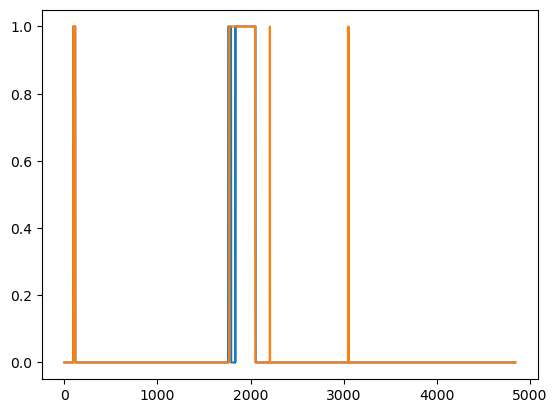

In [53]:
plt.plot(ym_predictions)
plt.plot(ym_test.reset_index(drop=True))

C:\Users\aboas\AppData\Local\Temp\ipykernel_14616\1601252764.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(ym_test[70:150].reset_index(drop=True))


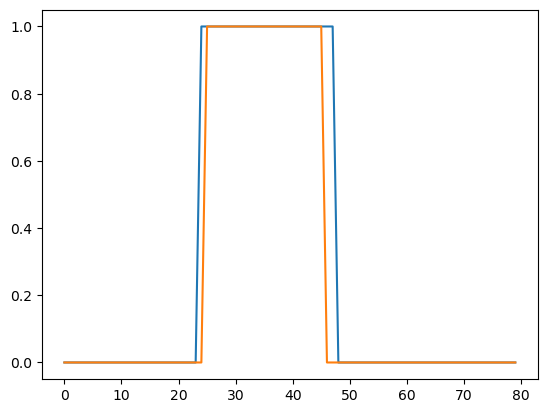

In [54]:
plt.plot(ym_predictions[70:150])
plt.plot(ym_test[70:150].reset_index(drop=True))

interchange the test and train data:

In [55]:
Xm2_train, Xm2_test, ym2_train, ym2_test = X_sc[2500:],X_sc[:2500],Y[2500:],Y[:2500]

In [56]:
%%time
# instantiate the model (using the default parameters)
start=time.time()
model = LogisticRegression(random_state=16).fit(Xm2_train, ym2_train)
end_train=time.time()
ym2_predictions = model.predict(Xm2_test)
end_predict=time.time()

model_performance.loc['scaled Logistic Regression2'] = [model.score(Xm2_test,ym2_test), 
                                   mean_squared_error(ym2_test,ym2_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(Xm2_test,ym2_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(ym2_test,ym2_predictions,squared=False)))

R-squared error: 99.12%
Root Mean Squared Error: 0.09
CPU times: total: 15.6 ms
Wall time: 15 ms


In [57]:
cnf_matrix = sklearn.metrics.confusion_matrix(ym2_test, ym2_predictions)
cnf_matrix

array([[2296,   22],
       [   0,  182]], dtype=int64)

In [58]:
22/(2296+22+182)

0.0088

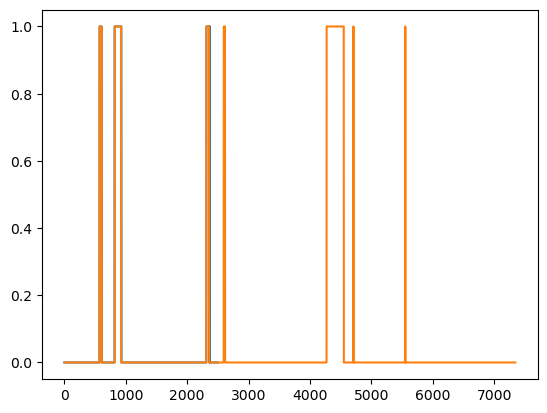

In [59]:
plt.plot(ym2_predictions)
plt.plot(Y)

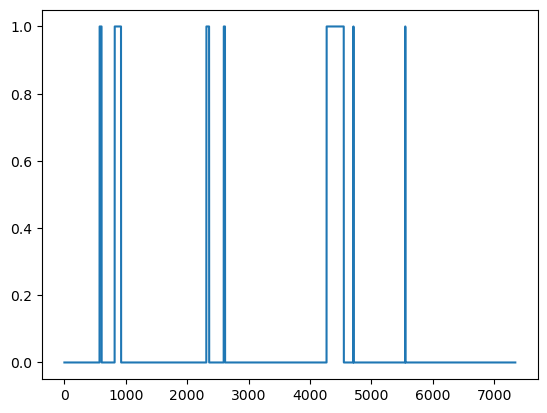

In [60]:
plt.plot(Y)

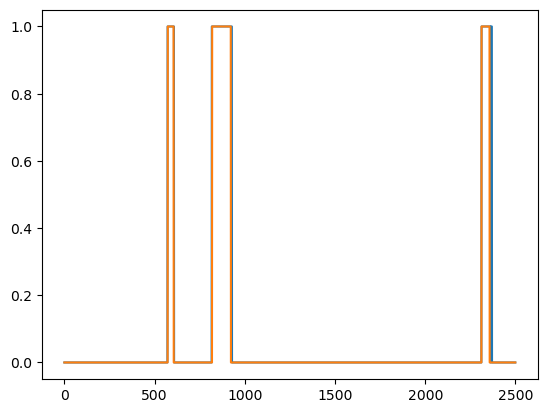

In [61]:
plt.plot(ym2_predictions)
plt.plot(ym2_test.reset_index(drop=True))

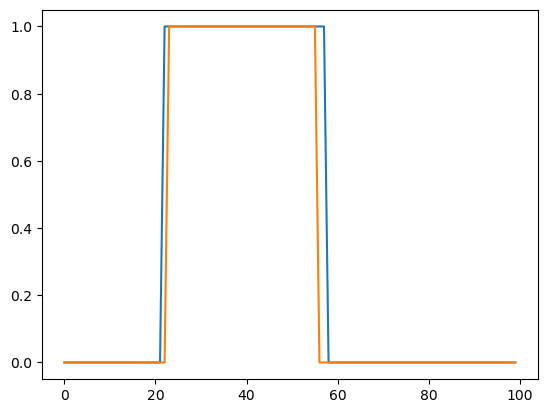

In [62]:
plt.plot(ym2_predictions[550:650])
plt.plot(ym2_test[550:650].reset_index(drop=True))

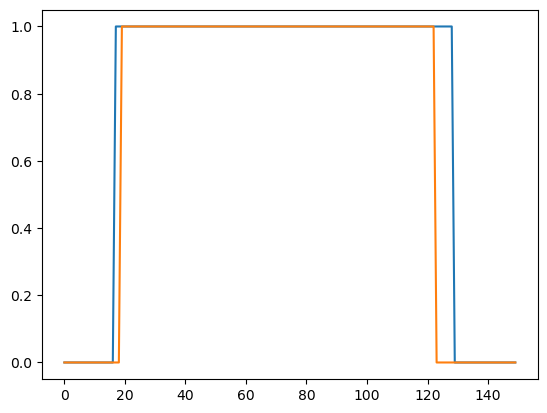

In [63]:
plt.plot(ym2_predictions[800:950])
plt.plot(ym2_test[800:950].reset_index(drop=True))

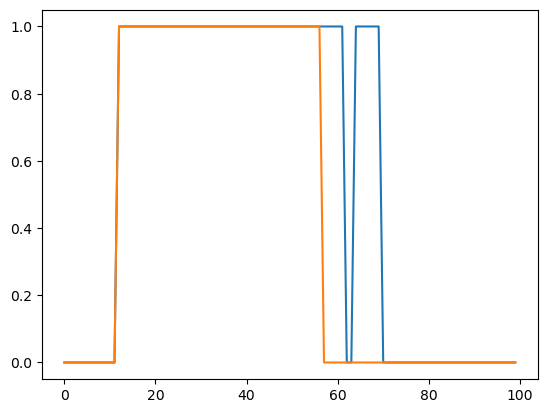

In [64]:
plt.plot(ym2_predictions[2300:2400])
plt.plot(ym2_test[2300:2400].reset_index(drop=True))

# Conclusion:

I built a model to predict the break down of a machine before it breaks down. 
The Logistic regression  models works best on the test data. In the zoomed in plots one can see that the blue(=predicted) line rises earlier than the orange(=data) line. Thus we know beforehand if an Error occurs and can work on preventing that.

I did not explore different bin sizes nor larger target shifts. Also there are many other models that can be used.

# RUL Analysis

In [227]:
ErrorTimes=[0]+list(data0[data0['machine_status']==1].index)
ErrorTimes

[0, 17155, 24510, 69318, 77790, 128040, 141131, 166440]

In [228]:
Life=np.array([])
for x in range(1,len(ErrorTimes)):
    Life=np.append(Life,ErrorTimes[x]-ErrorTimes[x-1])

In [229]:
Life

array([17155.,  7355., 44808.,  8472., 50250., 13091., 25309.])

In [230]:
data0['RUL']=np.NaN
for x in range(1,len(ErrorTimes)):
    data0['RUL'][ErrorTimes[x-1]+1:ErrorTimes[x]+1]=ErrorTimes[x]-data0['Unnamed: 0'][ErrorTimes[x-1]+1:ErrorTimes[x]+1]

C:\Users\aboas\AppData\Local\Temp\ipykernel_14616\2658872693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data0['RUL'][ErrorTimes[x-1]+1:ErrorTimes[x]+1]=ErrorTimes[x]-data0['Unnamed: 0'][ErrorTimes[x-1]+1:ErrorTimes[x]+1]


In [231]:
data0['RUL'][166438:166445]

166438    2.0
166439    1.0
166440    0.0
166441    NaN
166442    NaN
166443    NaN
166444    NaN
Name: RUL, dtype: float64

In [232]:
data0['RUL'][17150:17160]

17150       5.0
17151       4.0
17152       3.0
17153       2.0
17154       1.0
17155       0.0
17156    7354.0
17157    7353.0
17158    7352.0
17159    7351.0
Name: RUL, dtype: float64

In [233]:
data0['RUL'][data0['RUL']>250]=250
#data0['RUL'].fillna(250, inplace=True)

C:\Users\aboas\AppData\Local\Temp\ipykernel_14616\1306582595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data0['RUL'][data0['RUL']>250]=250


In [234]:
data0.dropna(inplace=True)

In [235]:
data0

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_05,sensor_06,sensor_07,sensor_11,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,machine_status,RUL
1,1,2018-04-01 00:01:00,2.465394,47.092010,53.21180,46.310760,76.45975,13.41146,16.13136,47.52422,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,0.0,250.0
2,2,2018-04-01 00:02:00,2.444734,47.352430,53.21180,46.397570,73.54598,13.32465,16.03733,48.17723,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,0.0,250.0
3,3,2018-04-01 00:03:00,2.460474,47.092010,53.16840,46.397568,76.98898,13.31742,16.24711,48.65607,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,0.0,250.0
4,4,2018-04-01 00:04:00,2.445718,47.135410,53.21180,46.397568,76.58897,13.35359,16.21094,49.06298,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,0.0,250.0
5,5,2018-04-01 00:05:00,2.453588,47.092010,53.16840,46.397568,78.18568,13.41146,16.16753,49.37051,...,42.70833,38.773150,63.65741,51.79398,38.773150,164.6412,66.55093,241.6088,0.0,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166436,166436,2018-07-25 13:56:00,2.313889,45.833330,53.03819,43.923610,73.00980,14.36632,16.21094,49.88500,...,49.47916,52.083330,51.79398,60.47454,45.138890,252.3148,69.15509,198.2060,0.0,4.0
166437,166437,2018-07-25 13:57:00,2.315856,45.833332,53.03819,43.923611,72.47576,14.33015,16.16030,49.96759,...,49.47916,52.083330,51.21528,60.47454,44.849540,253.1829,71.46991,202.8356,0.0,3.0
166438,166438,2018-07-25 13:58:00,2.322743,45.833330,52.99479,43.923610,70.48889,14.46036,16.16030,49.75908,...,49.73958,52.083330,52.08333,61.34259,44.849540,249.1319,72.33796,206.8866,0.0,2.0
166439,166439,2018-07-25 13:59:00,2.315856,45.789930,53.03819,43.880210,68.74365,14.43866,16.07350,49.73039,...,50.52083,52.662040,53.24074,63.36805,44.849540,244.5023,72.62731,209.7801,0.0,1.0


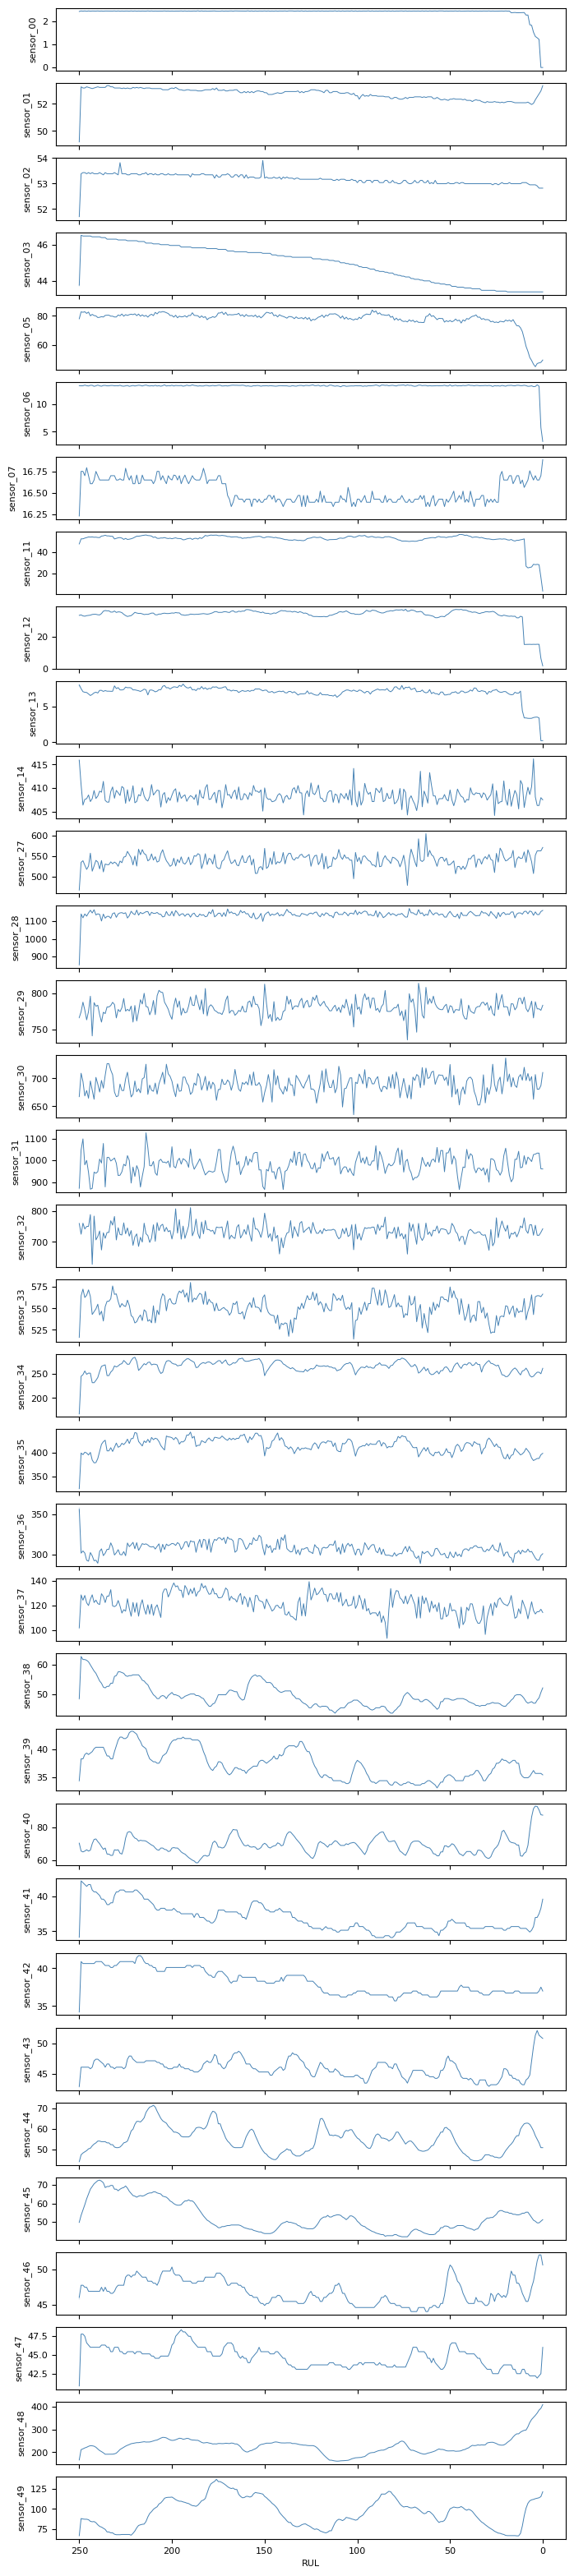

In [236]:
plt.rcParams['figure.figsize']=8,40 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 8
plt.rcParams['lines.linewidth'] = 0.7
plot_items = list(data0.columns)[2:-3]
fig,ax = plt.subplots(len(plot_items),sharex=True)
ax[0].invert_xaxis()

for i,item in enumerate(plot_items):
        f = sns.lineplot(data=data0[:17156],x='RUL',y=item,color='steelblue',ax=ax[i],
                        )

In [237]:
X=data0.drop(['Unnamed: 0','timestamp','machine_status','RUL'],axis=1)
y=data0['RUL']

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

In [239]:
backward_regression(X, y)

worst_feature : sensor_32, 0.9205133097470453 
worst_feature : sensor_37, 0.7700348859132695 
worst_feature : sensor_39, 0.358658523871655 
worst_feature : sensor_46, 0.2111358769079463 
worst_feature : sensor_45, 0.5528601095940006 
worst_feature : sensor_34, 0.1450255676468938 

Selected Features:
['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_14', 'sensor_28', 'sensor_31', 'sensor_32', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_47', 'sensor_48', 'sensor_49']


In [240]:
backward_regression(X_train, y_train)

worst_feature : sensor_27, 0.7791999615828666 
worst_feature : sensor_42, 0.22111859440531964 
worst_feature : sensor_12, 0.17097212060583467 
worst_feature : sensor_14, 0.1330903977141118 
worst_feature : sensor_43, 0.052584040574247565 
worst_feature : sensor_45, 0.05661520840187772 
worst_feature : sensor_49, 0.051498674899972424 

Selected Features:
['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_14', 'sensor_28', 'sensor_31', 'sensor_32', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_47', 'sensor_48', 'sensor_49']


In [241]:
sc = MinMaxScaler()
Xsc_train = sc.fit_transform(X_train)
Xsc_test = sc.transform(X_test)

<AxesSubplot: >

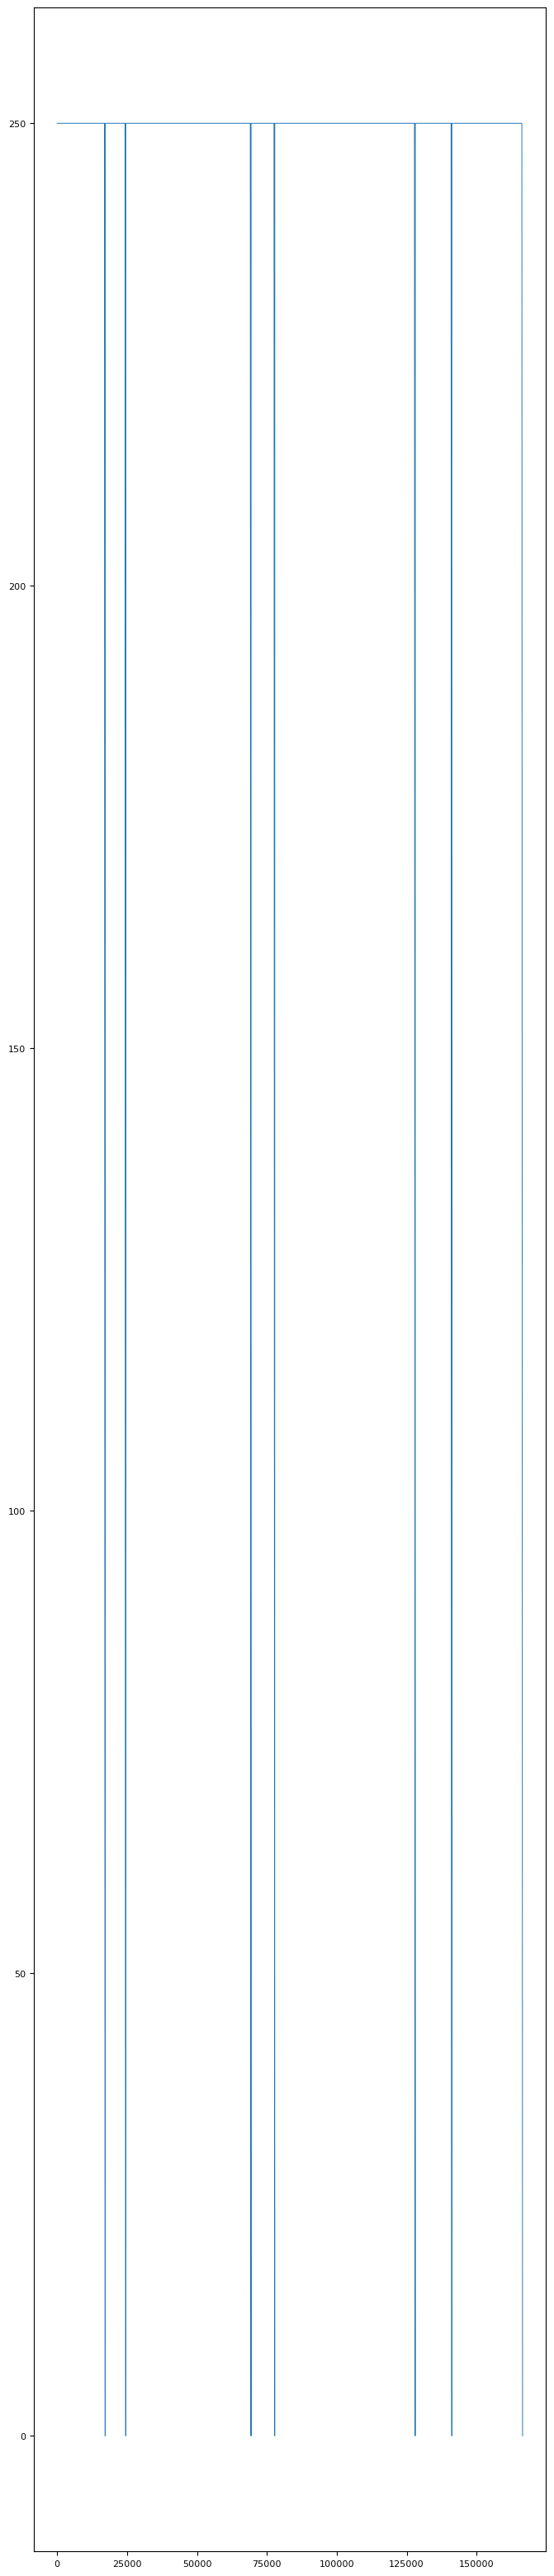

In [242]:
y.plot()

### KNN

In [243]:
%%time
from sklearn.neighbors import KNeighborsRegressor
start = time.time()
model = KNeighborsRegressor(n_neighbors=25).fit(Xsc_train,y_train)
end_train = time.time()
y_predictions = model.predict(Xsc_test) # These are the predictions from the test data.
end_predict = time.time()



model_performance.loc['kNN'] = [model.score(Xsc_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(Xsc_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: -347.65%
Root Mean Squared Error: 28.98
CPU times: total: 2min 35s
Wall time: 13.7 s


In [244]:
%%time
from sklearn.neighbors import KNeighborsRegressor
start = time.time()
model = KNeighborsRegressor(n_neighbors=9).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()



model_performance.loc['kNN'] = [model.score(X_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: -1.29%
Root Mean Squared Error: 13.78
CPU times: total: 2min 32s
Wall time: 13.2 s


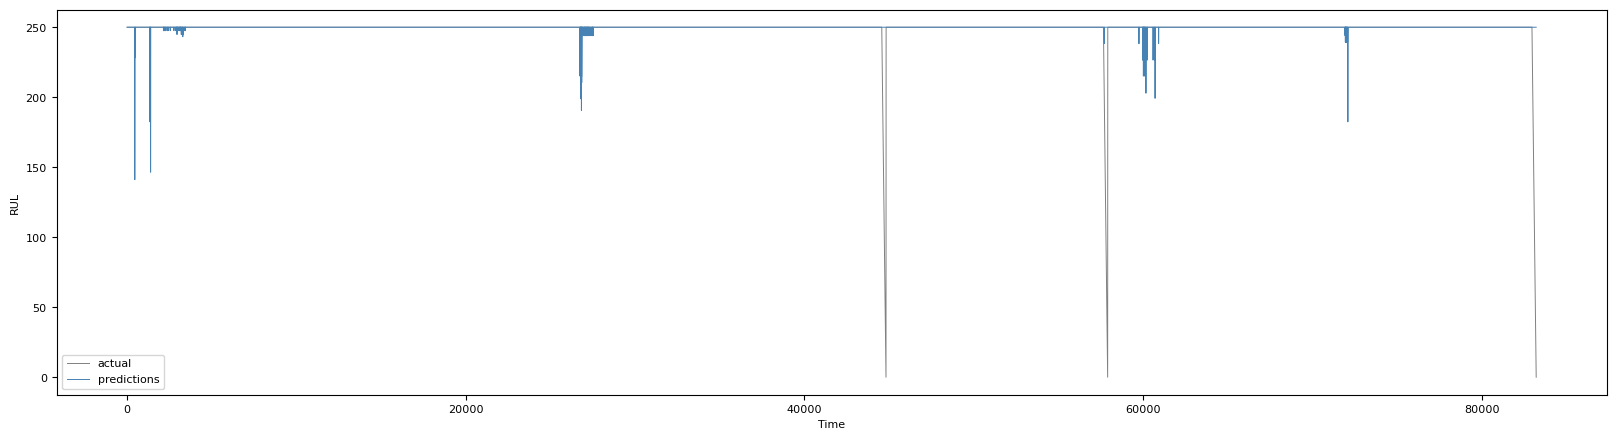

In [245]:
plt.rcParams['figure.figsize']=20,5 

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Time')

g = sns.lineplot(x = np.arange(0,len(X_test)),
                y=y_test,
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(X_test)),
                y=y_predictions,
                color='steelblue',
                label = 'predictions',
                ax=ax)
ax.legend()

## SVM

In [ ]:
%%time
from sklearn.svm import SVR
start = time.time()
model = SVR(kernel="rbf", C=100, gamma=0.5, epsilon=0.01).fit(Xsc_train,y_train)
end_train = time.time()
y_predictions = model.predict(Xsc_test) # These are the predictions from the test data.
end_predict = time.time()

model_performance.loc['SVM'] = [model.score(Xsc_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(Xsc_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

## Random Forest

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor
start = time.time()
model = RandomForestRegressor(n_jobs=-1,
                              n_estimators=500,
                              min_samples_leaf=1,
                              max_features='sqrt',
                             ).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

model_performance.loc['Random Forest'] = [model.score(X_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: -290.26%
Root Mean Squared Error: 27.06
CPU times: total: 1min 24s
Wall time: 7.63 s


In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor
start = time.time()
model = RandomForestRegressor(n_jobs=-1,
                              n_estimators=500,
                              min_samples_leaf=1,
                              max_features='sqrt',
                             ).fit(Xsc_train,y_train)
end_train = time.time()
y_predictions = model.predict(Xsc_test) # These are the predictions from the test data.
end_predict = time.time()

model_performance.loc['Random Forest'] = [model.score(Xsc_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(Xsc_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: -356.04%
Root Mean Squared Error: 29.25
CPU times: total: 1min 23s
Wall time: 7.49 s


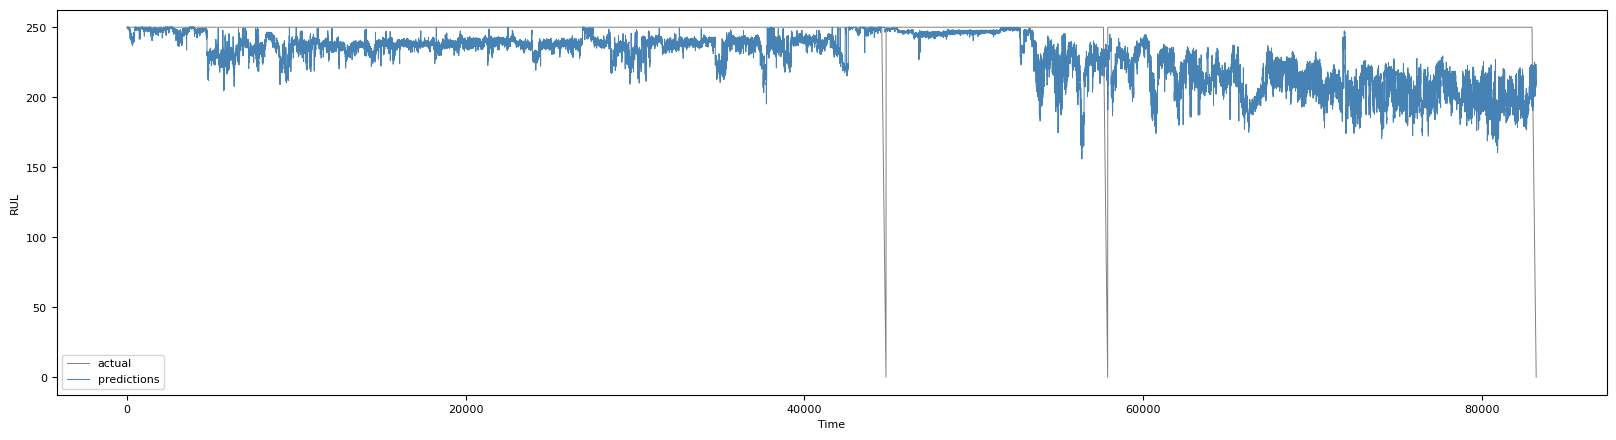

In [ ]:
plt.rcParams['figure.figsize']=20,5 

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Time')

g = sns.lineplot(x = np.arange(0,len(X_test)),
                y=y_test,
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(X_test)),
                y=y_predictions,
                color='steelblue',
                label = 'predictions',
                ax=ax)
ax.legend()

## Logistic Regression

In [252]:
%%time
# instantiate the model (using the default parameters)
start=time.time()
model = LogisticRegression(random_state=16,max_iter=400).fit(Xsc_train, y_train)
end_train=time.time()
y_predictions = model.predict(Xsc_test)
end_predict=time.time()

model_performance.loc['scaled Logistic Regression2'] = [model.score(Xsc_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(Xsc_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: 67.51%
Root Mean Squared Error: 92.17
CPU times: total: 6min 20s
Wall time: 1min 2s


In [250]:
%%time
# instantiate the model (using the default parameters)
start=time.time()
model = LogisticRegression(random_state=16,max_iter=400).fit(X_train, y_train)
end_train=time.time()
y_predictions = model.predict(X_test)
end_predict=time.time()

model_performance.loc['scaled Logistic Regression2'] = [model.score(X_test,y_test), 
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

C:\Users\aboas\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


R-squared error: 39.76%
Root Mean Squared Error: 59.29
CPU times: total: 14min 44s
Wall time: 2min 27s


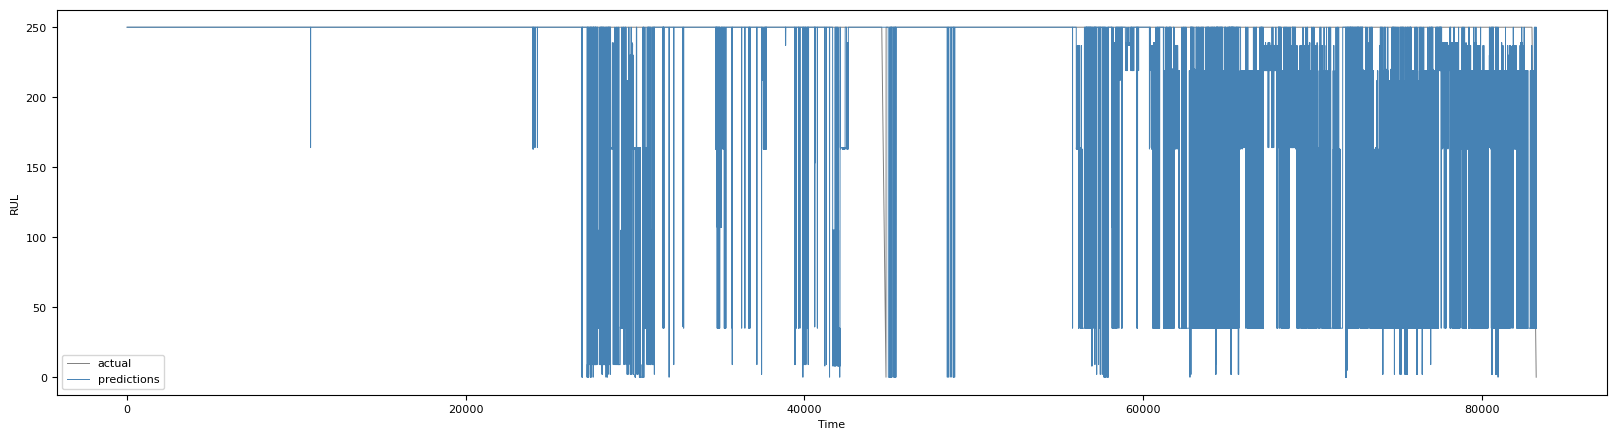

In [253]:
plt.rcParams['figure.figsize']=20,5 

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Time')

g = sns.lineplot(x = np.arange(0,len(X_test)),
                y=y_test,
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(X_test)),
                y=y_predictions,
                color='steelblue',
                label = 'predictions',
                ax=ax)
ax.legend()